# Importing all the useful stuff. I'll be adding new cells below as I remember to import things

In [4]:
import numpy as np                 
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Activation, GlobalMaxPooling2D, Dense, MaxPooling2D, Flatten
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers
import keras

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split
import h5py

In [0]:
import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
import math

# Importing libraries to setup google drive.

In [8]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Function for loading data from the hdf5 file stored on google drive

In [0]:
def load_data():
  link1 = 'https://drive.google.com/open?id=12PQqDemBZ_XgQSbpFl2F6hXDkqQGTnmf'
  fluff, id = link1.split('=')
  print(id)
  download1 = drive.CreateFile({'id':id})
  download1.GetContentFile('photon.hdf5')
  f = h5py.File('photon.hdf5', 'r')
  p_X = f['X']
  p_y = f['y']
  link2 = 'https://drive.google.com/open?id=1lW1jdrRGAMWcOrma7fqYXJfErk6ah_qS'
  fluff, id = link2.split('=')
  download2 = drive.CreateFile({'id':id})
  download2.GetContentFile('electron.hdf5')
  e = h5py.File('electron.hdf5', 'r')
  e_X = e['X']
  e_y = e['y']
  return p_X, p_y, e_X, e_y

# Concatenating the photon and electron data, and shuffling the data. Also splitting the data into train, test validation. Ration is 80:10:10

In [0]:
def prepare_data(p_X, p_y, e_X, e_y):
  p_X = np.array(p_X)
  p_y = np.array(p_y)
  e_X = np.array(e_X)
  e_y = np.array(e_y)
  X_train = np.concatenate((p_X, e_X), axis = 0)
  y_train = np.concatenate((p_y, e_y), axis = 0)
  indices = np.arange(X_train.shape[0])
  np.random.shuffle(indices)
  X_train = X_train[indices]
  y_train = y_train[indices]
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
  return X_train, y_train, X_test, y_test, X_val, y_val

# Residual block, an important unit of the resnet architecture. I've implemented it similar to the paper, to the best of my understanding

In [0]:
def res_block (n_output, s, upscale = False):
  def f(x):
    
    h = Conv2D(kernel_size=3, filters=n_output, strides=s,padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    h = Activation('relu')(h)
    
    h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
    
    if upscale:
        f = Conv2D(kernel_size=1, filters=n_output, strides=s, padding='same')(x)
    else:
        f = x
    
    return Activation('relu')(add([f,h]))
  return f

# Resnet

In [0]:
input_tensor = Input((32, 32, 2))
x = Conv2D(kernel_size=7, filters=16, strides=2, padding='same')(input_tensor)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = res_block(16, 1)(x)
x = res_block(16, 1)(x)
x = res_block(16, 1)(x)
x = res_block(32, 2, upscale=True)(x)
x = res_block(32, 1)(x)
x = res_block(32, 1)(x)
x = res_block(32, 1)(x)
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

In [0]:
model = Model(inputs=input_tensor, outputs=x)

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 32, 32, 2)    0                                            
__________________________________________________________________________________________________
conv2d_239 (Conv2D)             (None, 16, 16, 16)   1584        input_23[0][0]                   
__________________________________________________________________________________________________
activation_221 (Activation)     (None, 16, 16, 16)   0           conv2d_239[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 8, 8, 16)     0           activation_221[0][0]             
____________________________________________________________________________________________

# Optimizer is defined and model is compiled

In [0]:
opt = keras.optimizers.Adam(lr=5*10**(-4),decay=1e-6)

In [0]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
p_X, p_y, e_X, e_y = load_data()
X_train, y_train, X_test, y_test, X_val, y_val = prepare_data(p_X, p_y, e_X, e_y)

12PQqDemBZ_XgQSbpFl2F6hXDkqQGTnmf


In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), shuffle=True)

Train on 398400 samples, validate on 49800 samples
Epoch 1/30
398400/398400 [==============================] - 147s 370us/step - loss: 0.6584 - acc: 0.6340 - val_loss: 0.6100 - val_acc: 0.6743
Epoch 2/30
398400/398400 [==============================] - 142s 357us/step - loss: 0.6020 - acc: 0.6826 - val_loss: 0.5999 - val_acc: 0.6858
Epoch 3/30
398400/398400 [==============================] - 143s 359us/step - loss: 0.5918 - acc: 0.6916 - val_loss: 0.5890 - val_acc: 0.6969
Epoch 4/30
398400/398400 [==============================] - 141s 355us/step - loss: 0.5856 - acc: 0.6964 - val_loss: 0.5845 - val_acc: 0.6983
Epoch 5/30
398400/398400 [==============================] - 139s 348us/step - loss: 0.5813 - acc: 0.7005 - val_loss: 0.5865 - val_acc: 0.7003
Epoch 6/30
398400/398400 [==============================] - 137s 343us/step - loss: 0.5776 - acc: 0.7039 - val_loss: 0.5815 - val_acc: 0.7020
Epoch 7/30
398400/398400 [==============================] - 137s 344us/step - loss: 0.5752 - acc:

Loss Curve

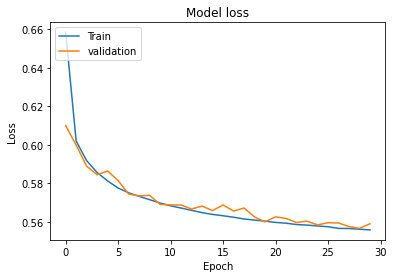

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation', 'train', 'val'], loc='upper left')
plt.show()

In [0]:
model.evaluate(x=X_test, y=y_test)

49800/49800 [==============================] - 5s 100us/step


[0.5626343705472219, 0.7169477911646587]

In [0]:
def eval(X_test, y_test):
  return model.evaluate(x=X_test, y=y_test)

In [0]:
def predict(X_test):
  return model.predict(x=X_test)

In [0]:
with open('./model.pkl','wb') as model_pkl:
  pickle.dump(model, model_pkl)

# 1 channel.

In [26]:
p_X, p_y, e_X, e_y = load_data()
X_train1, y_train1, X_test1, y_test1, X_val1, y_val1 = prepare_data(p_X, p_y, e_X, e_y)
X_train1, X_test1, X_val1 = X_train1[...,0], X_test1[...,0], X_val1[...,0]

12PQqDemBZ_XgQSbpFl2F6hXDkqQGTnmf


In [13]:
input_tensor2 = Input((32, 32, 1))
x = Conv2D(kernel_size=7, filters=16, strides=2, padding='same')(input_tensor2)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = res_block(16, 1)(x)
x = res_block(16, 1)(x)
x = res_block(16, 1)(x)
x = res_block(32, 2, upscale=True)(x)
x = res_block(32, 1)(x)
x = res_block(32, 1)(x)
x = res_block(32, 1)(x)
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

In [0]:
model2 = Model(inputs=input_tensor2, outputs=x)

In [0]:
opt2 = keras.optimizers.Adam(lr=(5*(10**-4)))

In [0]:
def step_decay(epoch):
   initial_lrate = 5*(10**-4)
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get("loss"))
       self.lr.append(step_decay(len(self.losses)))

loss_history = LossHistory()
lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [0]:
model2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])

In [0]:
X_train1 = X_train1.reshape(-1, 32, 32, 1)
X_test1 = X_test1.reshape(-1, 32, 32, 1)
X_val1 = X_val1.reshape(-1, 32, 32, 1)

In [0]:
history2 = model2.fit(X_train1, y_train1, batch_size=32, epochs=30, callbacks=callbacks_list, validation_data=(X_val1, y_val1), shuffle=True)

# Loss Curve

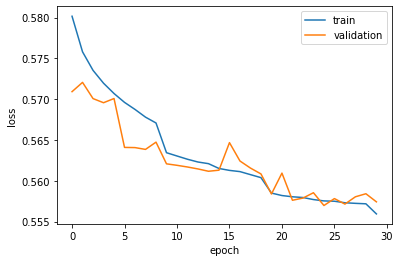

In [33]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

Test Accuracy

In [40]:
test_acc = model2.evaluate(X_test1, y_test1)
print(test_acc)

49800/49800 [==============================] - 9s 187us/step
[0.558176478765097, 0.7219678714859438]


In [0]:
y_pred = model2.predict(X_test1)

# AUC for **ROC**

In [37]:
roc_auc = roc_auc_score(y_test1, y_pred)
print(roc_auc)

0.7847767603011646


# ROC Curve

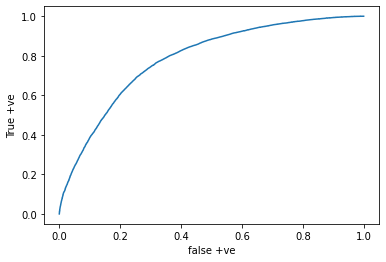

In [38]:
fpr, tpr, _ = roc_curve(y_test1, y_pred)
plt.plot(fpr, tpr, label='Resnet')
plt.xlabel('false +ve')
plt.ylabel('True +ve')
plt.show()

In [0]:
with open('./model_2.pkl','wb') as model_pkl:
  pickle.dump(model2, model_pkl)